## **Method of Unbiased Estimators**

#### Main Method

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5659690467417032
Epoch 200, Unbiased Loss: 0.5449741116650932
Epoch 300, Unbiased Loss: 0.537702152078586
Epoch 400, Unbiased Loss: 0.5345323891526399
Epoch 500, Unbiased Loss: 0.532983634496632
Epoch 600, Unbiased Loss: 0.5321742651630121
Epoch 700, Unbiased Loss: 0.5317313863639453
Epoch 800, Unbiased Loss: 0.5314801012287301
Epoch 900, Unbiased Loss: 0.5313329085443945
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.47682145585215474
Epoch 200, Unbiased Loss: 0.43999344591385814
Epoch 300, Unbiased Loss: 0.42610839636219583
Epoch 400, Unbiased Loss: 0.4193455353891484
Epoch 500, Unbiased Loss: 0.4156040797361768
Epoch 600, Unbiased Loss: 0.41336518559853347
Epoch 700, Unbiased Loss: 0.4119493971384233
Epoch 800, Unbiased Loss: 0.4110160002430517
Epoch 900, Unbiased Loss: 0.41038039421508715
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5524745260440368
Epoch 200, Un

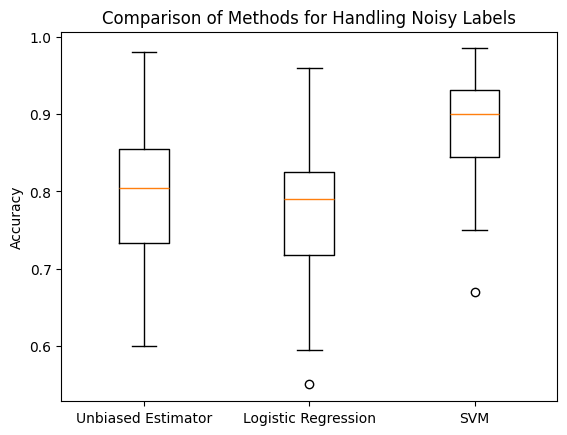

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
        
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg")

#### Main method with correlated features

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5681467681082087
Epoch 200, Unbiased Loss: 0.5380240036040866
Epoch 300, Unbiased Loss: 0.522869402318198
Epoch 400, Unbiased Loss: 0.5136729618131429
Epoch 500, Unbiased Loss: 0.5075741493804582
Epoch 600, Unbiased Loss: 0.503310851615663
Epoch 700, Unbiased Loss: 0.5002222883389372
Epoch 800, Unbiased Loss: 0.4979257635121278
Epoch 900, Unbiased Loss: 0.4961841584084016
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5516682897802658
Epoch 200, Unbiased Loss: 0.528364802761602
Epoch 300, Unbiased Loss: 0.5170805418851652
Epoch 400, Unbiased Loss: 0.5105080566685345
Epoch 500, Unbiased Loss: 0.5063114121925898
Epoch 600, Unbiased Loss: 0.5034744765476795
Epoch 700, Unbiased Loss: 0.5014787959044046
Epoch 800, Unbiased Loss: 0.500032964759114
Epoch 900, Unbiased Loss: 0.4989617954127077
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.540862644399045
Epoch 200, Unbiased L

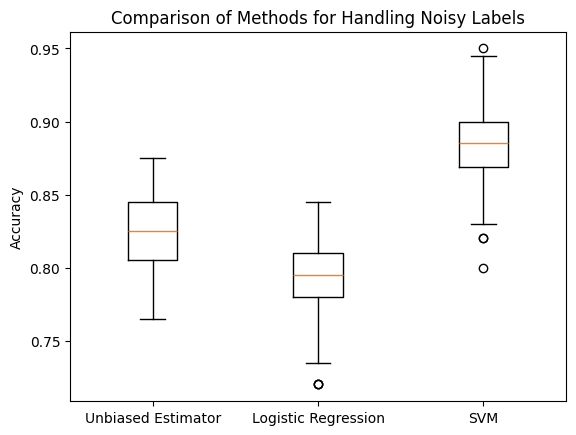

In [23]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, correlation=0.8, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.correlation = correlation  # Adding correlation parameter
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Consistent random generator
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self):
        """
        Generate a synthetic dataset with noisy labels and correlated features.
        """
        # Step 1: Generate data with make_classification (no correlation yet)
        X, y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, 
                                   n_redundant=3, n_informative=10, random_state=self.seed)
        y = np.where(y == 0, -1, 1)  # Remap labels to {-1, 1}
        
        # Step 2: Introduce correlation by making some features linear combinations of others
        X[:, 12] = self.correlation * X[:, 0] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)
        X[:, 13] = self.correlation * X[:, 1] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)
        X[:, 14] = self.correlation * X[:, 2] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)

        # Step 3: Add noise to labels
        y_noisy = y.copy()
        indices_class_1 = np.where(y == 1)[0]
        indices_class_minus_1 = np.where(y == -1)[0]
        
        # Flip a percentage of labels for each class
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        
        flip_indices_class_1 = self.rng.choice(indices_class_1, size=n_flip_class_1, replace=False)
        flip_indices_class_minus_1 = self.rng.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        
        y_noisy[flip_indices_class_1] = -y_noisy[flip_indices_class_1]
        y_noisy[flip_indices_class_minus_1] = -y_noisy[flip_indices_class_minus_1]
        
        # Store the generated data
        self.X, self.y, self.y_noisy = X, y, y_noisy

    def get_data(self):
        """
        Return the generated data.
        """
        self.generate_data()
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            self.rng = np.random.default_rng(self.seed + i)  # Update the seed for each dataset, keeping consistency
            datasets.append(self.get_data())
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
        
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    # plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg")


Introducing correlation makes the task easier for the models by providing reinforced patterns (redundant information) and reducing feature variability. This results in slightly better mean accuracy and lower standard deviation, as the models produce more consistent predictions across multiple datasets. The reduced dimensionality due to correlated features helps models generalize better and become more robust to noise, which explains the observed changes in performance.

##### Correlation with target variable

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.4111063127697053
Epoch 200, Unbiased Loss: 0.37246270822313676
Epoch 300, Unbiased Loss: 0.36254227527023325
Epoch 400, Unbiased Loss: 0.3593313108693677
Epoch 500, Unbiased Loss: 0.3581697502336136
Epoch 600, Unbiased Loss: 0.3577010224865239
Epoch 700, Unbiased Loss: 0.3574757202847153
Epoch 800, Unbiased Loss: 0.3573374622835519
Epoch 900, Unbiased Loss: 0.3572308391796092
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.40417930696928805
Epoch 200, Unbiased Loss: 0.36397258431429735
Epoch 300, Unbiased Loss: 0.353486289619527
Epoch 400, Unbiased Loss: 0.3500353904469569
Epoch 500, Unbiased Loss: 0.34876597153840594
Epoch 600, Unbiased Loss: 0.34824674954536716
Epoch 700, Unbiased Loss: 0.3479960037132754
Epoch 800, Unbiased Loss: 0.347843067808034
Epoch 900, Unbiased Loss: 0.3477263015888884
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.42187559818818626
Epoch 200, 

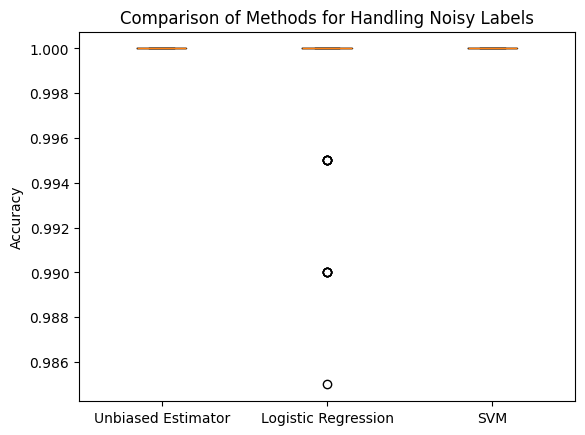

In [10]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, correlation=0.8, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.correlation = correlation  # Adding correlation parameter
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Consistent random generator
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self):
        """
        Generate a synthetic dataset with noisy labels and correlated features.
        """
        # Step 1: Generate class labels (y) first
        y = self.rng.choice([-1, 1], size=self.n_samples)

        # Step 2: Create features correlated with y
        X = np.zeros((self.n_samples, self.n_features))
        for i in range(self.n_features):
            X[:, i] = self.correlation * y + (1 - self.correlation) * self.rng.normal(size=self.n_samples)

        # Step 3: Add noise to labels
        y_noisy = y.copy()
        indices_class_1 = np.where(y == 1)[0]
        indices_class_minus_1 = np.where(y == -1)[0]
        
        # Flip a percentage of labels for each class using consistent RNG
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        
        flip_indices_class_1 = self.rng.choice(indices_class_1, size=n_flip_class_1, replace=False)
        flip_indices_class_minus_1 = self.rng.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        
        y_noisy[flip_indices_class_1] = -y_noisy[flip_indices_class_1]
        y_noisy[flip_indices_class_minus_1] = -y_noisy[flip_indices_class_minus_1]
        
        # Store the generated data
        self.X, self.y, self.y_noisy = X, y, y_noisy

    def get_data(self):
        """
        Return the generated data.
        """
        self.generate_data()
        return self.X, self.y, self.y_noisy
    
    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            self.rng = np.random.default_rng(self.seed + i)  # Update the seed for each dataset, keeping consistency
            datasets.append(self.get_data())
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
        
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    # plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="unbiased_estimator.jpg")


#### Hypothesis Testing
*Does the noise rate being fixed have an impact on the accuracy of the model?*

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5681467681082087
Epoch 200, Unbiased Loss: 0.5380240036040866
Epoch 300, Unbiased Loss: 0.522869402318198
Epoch 400, Unbiased Loss: 0.5136729618131429
Epoch 500, Unbiased Loss: 0.5075741493804582
Epoch 600, Unbiased Loss: 0.503310851615663
Epoch 700, Unbiased Loss: 0.5002222883389372
Epoch 800, Unbiased Loss: 0.4979257635121278
Epoch 900, Unbiased Loss: 0.4961841584084016
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.6101535599927186
Epoch 200, Unbiased Loss: 0.5936527673922257
Epoch 300, Unbiased Loss: 0.5860202630390708
Epoch 400, Unbiased Loss: 0.581722341362365
Epoch 500, Unbiased Loss: 0.5791268819630572
Epoch 600, Unbiased Loss: 0.5775066374655661
Epoch 700, Unbiased Loss: 0.5764741992799602
Epoch 800, Unbiased Loss: 0.5758062327402748
Epoch 900, Unbiased Loss: 0.5753686183521379
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5516682897802658
Epoch 200, Unbiased

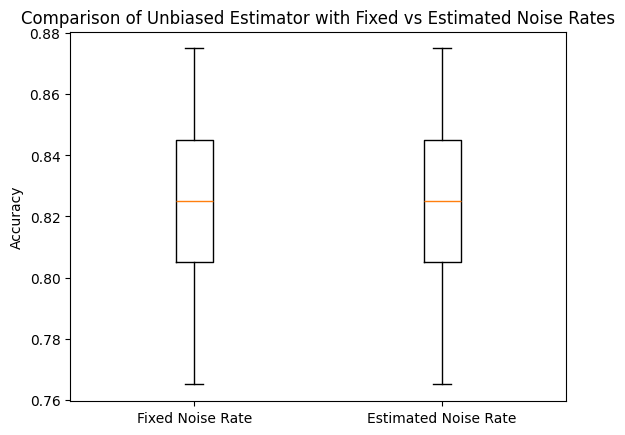

In [22]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, correlation=0.8, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.correlation = correlation  # Adding correlation parameter
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Consistent random generator
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self):
        """
        Generate a synthetic dataset with noisy labels and correlated features.
        """
        # Step 1: Generate data with make_classification (no correlation yet)
        X, y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, 
                                   n_redundant=3, n_informative=10, random_state=self.seed)
        y = np.where(y == 0, -1, 1)  # Remap labels to {-1, 1}
        
        # Step 2: Introduce correlation by making some features linear combinations of others
        X[:, 12] = self.correlation * X[:, 0] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)
        X[:, 13] = self.correlation * X[:, 1] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)
        X[:, 14] = self.correlation * X[:, 2] + (1 - self.correlation) * self.rng.normal(size=self.n_samples)

        # Step 3: Add noise to labels
        y_noisy = y.copy()
        indices_class_1 = np.where(y == 1)[0]
        indices_class_minus_1 = np.where(y == -1)[0]
        
        # Flip a percentage of labels for each class
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        
        flip_indices_class_1 = self.rng.choice(indices_class_1, size=n_flip_class_1, replace=False)
        flip_indices_class_minus_1 = self.rng.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        
        y_noisy[flip_indices_class_1] = -y_noisy[flip_indices_class_1]
        y_noisy[flip_indices_class_minus_1] = -y_noisy[flip_indices_class_minus_1]
        
        # Store the generated data
        self.X, self.y, self.y_noisy = X, y, y_noisy

    def get_data(self):
        """
        Return the generated data.
        """
        self.generate_data()
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            self.rng = np.random.default_rng(self.seed + i)  # Update the seed for each dataset, keeping consistency
            datasets.append(self.get_data())
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Estimate noise rates using logistic regression
def estimate_noise_rate(X_train, y_train_noisy, threshold=0.9):
    model = LogisticRegression()
    model.fit(X_train, y_train_noisy)
    probs = model.predict_proba(X_train)
    probs_positive = probs[:, 1]  # Probability of the positive class

    positive_errors = (probs_positive > threshold) & (y_train_noisy == -1)
    negative_errors = (probs_positive < (1 - threshold)) & (y_train_noisy == 1)

    estimated_rho_plus = np.mean(positive_errors)
    estimated_rho_minus = np.mean(negative_errors)

    return estimated_rho_plus, estimated_rho_minus

# Main simulation function for both fixed and estimated noise rates
def simulation_study_unbiased_estimator(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_fixed = []
    accuracies_estimated = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Scenario 1: Fixed Noise Rates
        T_fixed = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        weights_fixed = train_custom_logistic_regression(X_train, y_train_noisy, T_fixed, learning_rate, epochs)
        y_pred_fixed = np.sign(np.dot(X_test, weights_fixed))
        accuracy_fixed = accuracy_score(y_test_clean, y_pred_fixed)
        accuracies_fixed.append(accuracy_fixed)
        
        # Scenario 2: Estimated Noise Rates
        estimated_rho_plus, estimated_rho_minus = estimate_noise_rate(X_train, y_train_noisy)
        T_estimated = define_noise_transition_matrix(estimated_rho_plus, estimated_rho_minus)
        weights_estimated = train_custom_logistic_regression(X_train, y_train_noisy, T_estimated, learning_rate, epochs)
        y_pred_estimated = np.sign(np.dot(X_test, weights_estimated))
        accuracy_estimated = accuracy_score(y_test_clean, y_pred_estimated)
        accuracies_estimated.append(accuracy_estimated)
    
    return accuracies_fixed, accuracies_estimated

# Run the simulation study for both fixed and estimated noise rates
accuracies_fixed, accuracies_estimated = simulation_study_unbiased_estimator(seed=42)

# Perform a paired t-test to check if there is a significant difference
t_statistic, p_value = stats.ttest_rel(accuracies_fixed, accuracies_estimated)
print(f"Paired t-test results: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

# Interpretation of the hypothesis test result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in performance.")

# Visualization: Compare the accuracies for fixed and estimated noise rates
def visualize_unbiased_estimator_comparison(accuracies_fixed, accuracies_estimated):
    data = [accuracies_fixed, accuracies_estimated]
    plt.boxplot(data, labels=['Fixed Noise Rate', 'Estimated Noise Rate'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Unbiased Estimator with Fixed vs Estimated Noise Rates')
    plt.show()

# Visualize the accuracies
visualize_unbiased_estimator_comparison(accuracies_fixed, accuracies_estimated)

## Calculate Cohen's d to measure effect size
# mean_fixed = np.mean(accuracies_fixed)
# mean_estimated = np.mean(accuracies_estimated)
# std_pooled = np.sqrt((np.std(accuracies_fixed, ddof=1) ** 2 + np.std(accuracies_estimated, ddof=1) ** 2) / 2)
# cohens_d = (mean_fixed - mean_estimated) / std_pooled
# print(f"Cohen's d: {cohens_d:.4f}")


#### Effect of Noise Rate on Accuracy

In [ ]:
def simulation_study_multiple_configs_unbiased(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    results = []

    for noise_rate_positive, noise_rate_negative in zip(noise_rate_positives, noise_rate_negatives):
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate_positive=noise_rate_positive,
                    noise_rate_negative=noise_rate_negative,
                    test_size=test_size,
                    learning_rate=learning_rate,
                    epochs=epochs,
                    seed=seed
                )
                print("Simulation run successful.")

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate_positive': noise_rate_positive,
                    'noise_rate_negative': noise_rate_negative,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results

# Example usage:
noise_rate_positives = [0.1, 0.2, 0.3]
noise_rate_negatives = [0.1, 0.2, 0.3]
n_features_list = [10, 20, 30]
n_samples_list = [1000, 2000, 3000]

results_unbiased = simulation_study_multiple_configs_unbiased(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, seed=42)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results_unbiased = pd.DataFrame(results_unbiased)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate_positive', y='mean_accuracy_weighted_lr', data=df_results_unbiased)
plt.title("Effect of Noise Rate on Unbiased Estimator Accuracy")
plt.show()


#### UCI Benchmark Dataset

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate_positive, noise_rate_negative, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "unbiased_estimator_uci.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods on Breast Cancer Benchmark Data')
    plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "unbiased_estimator_uci.jpg")